# Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Directories

In [ ]:
ROOT = '/content/drive/MyDrive/xBD_dataset/'

test = 'xView2_test/test/'
train = 'xView2_train/train/'
hold = 'xView2_hold/hold/'
tier3 = 'xView2_tier3/tier3/'

SUB = ['images', 'labels', 'targets']

## Libraries

In [ ]:
import os
import glob

import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
from time import sleep

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Concatenate, Conv2D, BatchNormalization, Activation, Dense
from keras.models import Model

import albumentations as A
from skimage.io import imread

## Read database

In [ ]:
with open(f'{ROOT}/All_Data_Props.pkl', 'rb') as f:
    db = pkl.load(f)

# Data Generator

Be careful about the data generator and image data types. They have changed based on model requirements.

In [ ]:
# More descriptions at the following link:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class xBD_DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 path_to_jsons,
                 batch_size=5,
                 patch_size=256,
                 shuffle=True,
                 classification=True, binary=False,
                 augmentation=None,     # None, 'light', 'medium', 'heavy'
                 # random_seed
                 ):

        '''
        https://keras.io/api/utils/python_utils/
        >>> *Sequence* class:
        Base object for fitting to a sequence of data, such as a dataset.

        Every Sequence must implement the __getitem__ and the __len__ methods.
        If you want to modify your dataset between epochs, you may implement
        on_epoch_end. The method __getitem__ should return a complete batch.

        Notes:
        Sequence is a safer way to do multiprocessing. This structure guarantees
        that the network will only train once on each sample per epoch,
        which is not the case with generators.

        '''

        # Initialization -->
        self.path_to_jsons = path_to_jsons
        self.pre_img_paths = []
        self.post_img_paths = []
        self.loc_target_paths = []
        self.cls_target_paths = []

        for i in range(len(self.path_to_jsons)):
            # pre-disaster images
            self.pre_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/') + '.png')
            # post-disaster images
            self.post_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/').replace('_pre_', '_post_') + '.png')
            if 'tier3' not in self.path_to_jsons[i]:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '_target.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_pre_', '_post_') + '_target.png')
            else:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_pre_', '_post_') + '.png')

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.classification = classification    # Whether you want to perform classification or localization.
        self.binary = binary                    # Whether you want to perform binary classification or not.
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

        self.augmentation = augmentation
        self.on_epoch_end()
        self.augment(self.augmentation)


    def __len__(self):
        # Denotes the number of batches per epoch (steps per epoch) [N_batch]
        return int(len(self.pre_img_paths) // self.batch_size)

    def __getitem__(self, idx):
        # Returns image indices of a batch
        # Generate one batch of data
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        pre_image_batch = list(np.array(self.pre_img_paths)[batch_indices])
        post_image_batch = list(np.array(self.post_img_paths)[batch_indices])
        loc_target_batch = list(np.array(self.loc_target_paths)[batch_indices])
        cls_target_batch = list(np.array(self.cls_target_paths)[batch_indices])

        # Generates data containing batch_size samples # X : (n_samples, *dim, n_channels)
        # Initialization
        x_pre_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        x_post_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        y_target_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (1,), dtype=int)
        # Generate data
        for b in range(self.batch_size):
            pre_image = imread(pre_image_batch[b]).astype('float32')
            post_image = imread(post_image_batch[b]).astype('float32')
            if self.classification:
                target_image = imread(cls_target_batch[b])
                if self.binary:
                    target_image[target_image == 2] = 1
                    target_image[target_image >= 3] = 2
            else:
                target_image = imread(loc_target_batch[b])

            if self.augmentation in ['light', 'medium', 'heavy']:
                transformation = self.augment(mode=self.augmentation)
                transformed = transformation(image=pre_image, image_post=post_image, mask=target_image)
                x_pre_batch[b] = (transformed['image'] / 255 - 0.5) * 2             # Scaling between [-1, 1] is required for MobileNet preprocessing.
                x_post_batch[b] = (transformed['image_post'] / 255 - 0.5) * 2       # Scaling between [-1, 1] is required for MobileNet preprocessing.
                y_target_batch[b, :, :, 0] = transformed['mask']
            elif self.augmentation is None:
                # Perform a random cropping and put images into batch array.
                r_start, c_start = np.random.randint(low=0, high=(pre_image.shape[0] - self.patch_size), size=2)
                x_pre_batch[b] = pre_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :] / 255
                x_post_batch[b] = post_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :] / 255
                y_target_batch[b, :, :, 0] = target_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size]

        # ({"x0": x0, "x1": x1}, y)
        # return (x_pre_batch, x_post_batch), y_target_batch
        return x_pre_batch, y_target_batch

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def augment(self, mode):
        if mode == 'light':
            transform = A.Compose([
                A.RandomCrop(width=self.patch_size, height=self.patch_size, p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
            ], additional_targets={'image_post': 'image'})

        elif mode == 'medium':
            transform = A.Compose([
                A.RandomCrop(width=self.patch_size, height=self.patch_size, p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ], additional_targets={'image_post': 'image'})

        elif mode == 'heavy':
            transform = A.Compose([
            A.RandomCrop(width=self.patch_size, height=self.patch_size, p=1),
            A.HorizontalFlip(p=0.65),
            A.VerticalFlip(p=0.65),
            A.RandomRotate90(p=0.65),
            A.Transpose(p=0.65),
            A.RandomBrightnessContrast(p=0.45),
            # A.Cutout(p=0.4),
            A.CoarseDropout(max_holes=12, max_height=20, max_width=20, p=0.7),
            A.OneOf([
                A.MotionBlur(p=0.4),
                A.MedianBlur(blur_limit=3, p=0.3),
                A.Blur(blur_limit=3, p=0.6),
                ], p=0.7),
            ], additional_targets={'image_post': 'image'})

        elif mode is None:
            transform = None
        else:
            transform = None
            ValueError('Augmentation must be one of light, medium, or heavy values.')

        return transform

# Create paths of train, test, validation splits

In [ ]:
# Training data generation
training_files = []
cond0 = db['Group'] == 'Train'                # use images in Train folder
cond1 = db['buildings#'] > 20                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'pre'               # choose from pre or post
training_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(training_files))

# Validation data generation
validation_files = []
cond0 = db['Group'] == 'Hold'                 # use images in Train folder
cond1 = db['buildings#'] > 30                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'pre'               # choose from pre or post
validation_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(validation_files))

# Testing data generation
testing_files = []
cond0 = db['Group'] == 'Test'                # use images in Train folder
cond1 = db['buildings#'] > 0                  # ensure there are buildings
cond2 = db['Pre_Post'] == 'pre'               # choose from pre or post
testing_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(testing_files))

1295
351
752


In [ ]:
BATCH_SIZE = 5
PATCH_SIZE = 256

parameters = {
    'shuffle': True,
    'batch_size': BATCH_SIZE,
    'patch_size': PATCH_SIZE,
    'classification': False,
    'binary': False,
    'augmentation': 'light'
}

train_generator = xBD_DataGenerator(path_to_jsons=training_files, **parameters)
test_generator = xBD_DataGenerator(path_to_jsons=testing_files, **parameters)
valid_generator = xBD_DataGenerator(path_to_jsons=validation_files, **parameters)

print(train_generator.__len__())
print(test_generator.__len__())
print(valid_generator.__len__())

259
150
70


## See some samples

Since the localization model is going to be trained, only the pre-images are used.

In [ ]:
# (x_pre_train, x_post_train), y_mask_train = train_generator.__getitem__(5)
x_pre_train, y_mask_train = train_generator.__getitem__(50)
print(x_pre_train.shape, y_mask_train.shape)

# (x_pre_test, x_post_test), y_mask_test = test_generator.__getitem__(5)
x_pre_test, y_mask_test = test_generator.__getitem__(26)
print(x_pre_test.shape, y_mask_test.shape)

# (x_pre_valid, x_post_valid), y_mask_valid = valid_generator.__getitem__(5)
x_pre_valid, y_mask_valid = valid_generator.__getitem__(63)
print(x_pre_valid.shape, y_mask_valid.shape)


c = mpl.colors.ListedColormap(['blue', 'green', 'cornsilk', 'orange', 'red'])
n = mpl.colors.Normalize(vmin=0, vmax=5)

plt.figure(figsize=(9, 9))
plt.subplot(331), plt.imshow(x_pre_train[1]), plt.title('pre train')
# plt.subplot(332), plt.imshow(x_post_train[0]), plt.title('post train')
plt.subplot(333), plt.imshow(y_mask_train[1], cmap=c, norm=n), plt.title('mask train')

plt.subplot(334), plt.imshow(x_pre_test[1]), plt.title('pre test')
# plt.subplot(335), plt.imshow(x_post_test[0]), plt.title('post test')
plt.subplot(336), plt.imshow(y_mask_test[1], cmap=c, norm=n), plt.title('mask test')

plt.subplot(337), plt.imshow(x_pre_valid[1]), plt.title('pre valid')
# plt.subplot(338), plt.imshow(x_post_valid[0]), plt.title('post valid')
plt.subplot(339), plt.imshow(y_mask_valid[1], cmap=c, norm=n), plt.title('mask valid')
plt.tight_layout()
plt.show()

In [ ]:
print(np.min(x_pre_train), np.max(x_pre_train))

# UNet (keras-unet-collection) + ResNet50

In [ ]:
!pip install keras-unet-collection

In [ ]:
from keras_unet_collection import models, utils

## Model definition

In [ ]:
model_localization_unet_resnet50 = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=2,
                                                  stack_num_down=2, stack_num_up=2, activation='GELU',
                                                  output_activation='Softmax',
                                                  batch_norm=True, pool='max', unpool='nearest',
                                                  backbone='ResNet50', weights='imagenet',
                                                  freeze_backbone=True, freeze_batch_norm=False,
                                                  name='localization_unet_resnet50')

# including_rescaling=False

94765736/94765736 [==============================] - 4s 0us/step


The `metrics` argument should be a list -- your model can have any number of metrics.

In [ ]:
# model_localization_unet_resnet50.compile(loss=keras.losses.categorical_crossentropy,
#                                          optimizer=keras.optimizers.SGD(learning_rate=1e-3))

# loss='binary_crossentropy'
model_localization_unet_resnet50.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))

## Callbacks

https://keras.io/api/callbacks/

In [ ]:
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, start_from_epoch=7, restore_best_weights=True),

    ModelCheckpoint(filepath='/content/model.unet-collection.localization.h5',
                    save_weights_only=True, save_best_only=False,
                    monitor="val_loss", mode="min"),

    ReduceLROnPlateau(monitor="val_loss", factor=0.33, patience=5, mode="min"),
]

## Fitting

This [link](https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn) is a great source for understanding how neural nets work, how to train them, and how they may face errors. The source can be used for writing the paper, too.

And, here's the detailed descriptions about how to use `fit` method.
https://keras.io/guides/training_with_built_in_methods/

In [ ]:
history = model_localization_unet_resnet50.fit(
    train_generator,
    validation_data=valid_generator,
    use_multiprocessing=True,
    workers=6, epochs=50,
    callbacks=my_callbacks
)

# If a loss increases to infinity it is a sign that the learning rate is too high.
# The reason that validation loss increases and validation accuracy increases could be due to data imbalance.
# https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy


In [ ]:
model_localization_unet_resnet50.load_weights('/content/model.unet-collection.localization.h5')

In [ ]:
for i in range(5):
    plt.figure()
    plt.imshow(b[i, :, :, 0])
    plt.show()

# MobileNet-UNet (keras applications)

## Construct the model

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_mobilenetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained MobileNetV2 Model """
    mobilenetv2 = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    mobilenetv2.trainable = False

    """ Encoder """
    s1 = mobilenetv2.get_layer("block_1_expand_relu").output
    s2 = mobilenetv2.get_layer("block_3_expand_relu").output
    s3 = mobilenetv2.get_layer("block_6_expand_relu").output
    s4 = mobilenetv2.get_layer("block_13_expand_relu").output

    """ Bridge """
    b1 = mobilenetv2.get_layer("out_relu").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    d5 = decoder_block(d4, inputs, 32)

    """ Output """
    # outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="MOBILENETV2_U-Net")
    return model

## Build model and get sample output

In [ ]:
model_mobilenet_unet = build_mobilenetv2_unet((256, 256, 3))

9406464/9406464 [==============================] - 0s 0us/step


(2, 256, 256, 1)


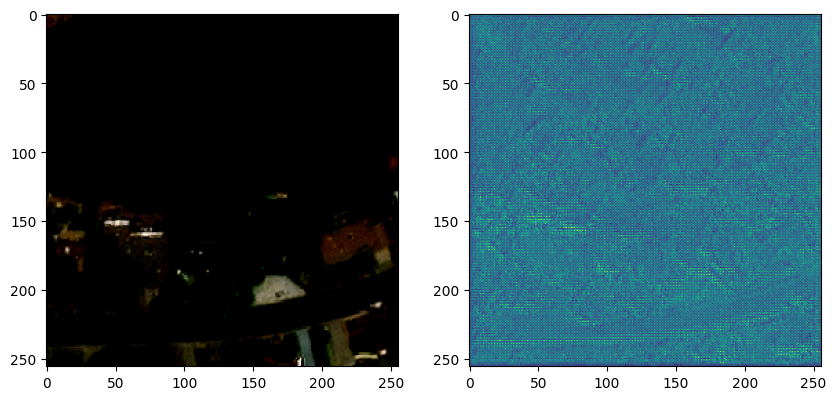

In [ ]:
out_mobilenet = model_mobilenet_unet(x_pre_test)
print(out_mobilenet.shape)

# Based on the documents, range of images must be between [-1, 1] for MobileNet networks.
# This may vary for different networks.

plt.figure(figsize=(10, 6))
plt.subplot(121), plt.imshow(x_pre_test[0, :, :, :])
plt.subplot(122), plt.imshow(out_mobilenet[0, :, :, 0])
plt.show()

## Hyperparameters

In [ ]:
# VERSION 1
model_mobilenet_unet.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, start_from_epoch=5, restore_best_weights=True),

    ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5',
                    save_weights_only=True, save_best_only=False,
                    monitor="val_loss", mode="min"),

    ReduceLROnPlateau(monitor="val_loss", factor=0.33, patience=5, mode="min"),
]

In [ ]:
# VERSION 2
model_path_save='/content/drive/MyDrive/model.mobilenet.v2.localization.unet.{epoch:02d}.h5'
check_point = ModelCheckpoint(model_path_save, verbose=1, save_best_only=True, monitor="val_loss")
early_stopping = EarlyStopping(monitor="val_loss", patience=25, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=25)
my_callbacks=[check_point,early_stopping,reduce_lr]

learning_rate = 0.01
decay_rate = learning_rate / 20
loss_binary= 'binary_crossentropy'
optimizer = Adam(lr=learning_rate, decay=decay_rate, epsilon=None)
model_mobilenet_unet.compile(loss=loss_binary, optimizer=optimizer, metrics=[MeanIoU(num_classes=2)])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Fitting

In [ ]:
history = model_mobilenet_unet.fit(
    train_generator,
    validation_data=valid_generator,
    use_multiprocessing=True,
    workers=6, epochs=50,
    callbacks=my_callbacks
)

## Loading trained weights

In [ ]:
model_mobilenet_unet.load_weights('/content/drive/MyDrive/model.mobilenet.v2.localization.unet.43.h5')

In [ ]:
a = model_mobilenet_unet.predict(x_pre_test)

1/1 [==============================] - 1s 1s/step


(<Axes: >, <matplotlib.image.AxesImage at 0x7979f72de1a0>)

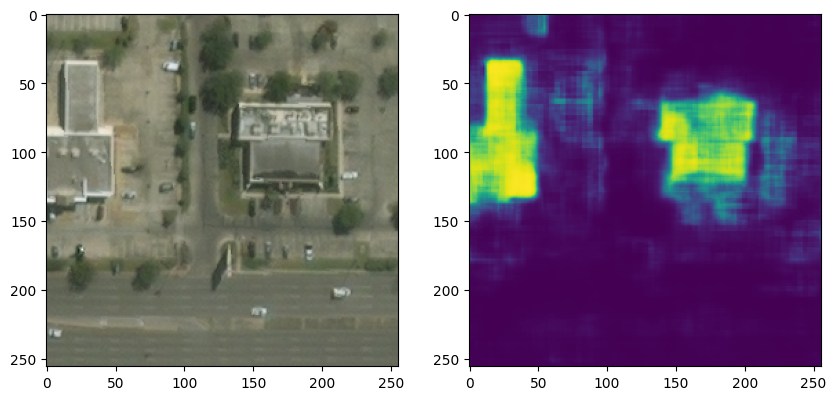

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(121), plt.imshow((x_pre_test[1, :, :, :]+1)/2)
plt.subplot(122), plt.imshow(a[1, :, :, 0])

---

# UNet (segmentation models: efficientnet and resnet)

https://github.com/qubvel/segmentation_models

In [ ]:
!pip install -U segmentation-models

In [ ]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm

import keras
keras.backend.set_image_data_format('channels_last')

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


## Definition

In [ ]:
def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

# https://stackoverflow.com/questions/60029027/decay-parameter-of-adam-optimizer-in-keras

In [ ]:
BACKBONE = 'efficientnetb7'
# BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
BATCH_SIZE = 5
CLASSES = ['building']
EPOCHS = 40
SCHEDULE = False

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# define optomizer
if SCHEDULE:
    LR = 0.01
    optimizer = keras.optimizers.Adam()
else:
    LR = 0.0001
    optimizer = keras.optimizers.Adam(LR)

lr_scheduler = LearningRateScheduler(decay_schedule)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/model.sm.{BACKBONE}.unet.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    # lr_scheduler,
]

# binary segmentation (this parameters are default when you call Unet('resnet34')
# if you set input channels not equal to 3, you have to set encoder_weights=None --> input_shape=(None, None, 6)
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#training-with-non-rgb-data
model_sm_unet = Unet(BACKBONE, classes=n_classes, encoder_weights='imagenet', encoder_freeze=True, activation=activation, input_shape=(None, None, 3))

model_sm_unet.compile(optimizer, loss=total_loss, metrics=metrics)

85521592/85521592 [==============================] - 2s 0us/step


In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model_sm_unet.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model_sm_unet.non_trainable_weights])
print(trainableParams)
print(nonTrainableParams)

11259153
63788944


## Data generator
: based on the required preprocessing functions of Segmentation Models.

In [ ]:
class xBD_DataGenerator(keras.utils.Sequence):
    def __init__(self, path_to_jsons, batch_size=5, patch_size=256,
                 shuffle=True, classification=True):

        # Initialization -->
        self.path_to_jsons = path_to_jsons
        self.pre_img_paths = []
        self.post_img_paths = []
        self.loc_target_paths = []
        self.cls_target_paths = []

        for i in range(len(self.path_to_jsons)):
            # pre-disaster images
            self.pre_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/') + '.png')
            # post-disaster images
            self.post_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/').replace('_pre_', '_post_') + '.png')
            if 'tier3' not in self.path_to_jsons[i]:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '_target.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_pre_', '_post_') + '_target.png')
            else:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_pre_', '_post_') + '.png')

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.classification = classification    # Whether you want to perform classification or localization.
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch (steps per epoch) [N_batch]
        return int(len(self.pre_img_paths) // self.batch_size)

    def __getitem__(self, idx):
        # Returns image indices of a batch
        # Generate one batch of data
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        pre_image_batch = list(np.array(self.pre_img_paths)[batch_indices])
        post_image_batch = list(np.array(self.post_img_paths)[batch_indices])
        loc_target_batch = list(np.array(self.loc_target_paths)[batch_indices])
        cls_target_batch = list(np.array(self.cls_target_paths)[batch_indices])

        # Generates data containing batch_size samples # X : (n_samples, *dim, n_channels)
        # Initialization
        x_pre_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        x_post_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        y_target_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (1,), dtype='float32')
        # Generate data
        for b in range(self.batch_size):
            pre_image = imread(pre_image_batch[b])
            post_image = imread(post_image_batch[b])
            if self.classification:
                target_image = imread(cls_target_batch[b])
                target_image[target_image == 5] = 1
            else:
                target_image = imread(loc_target_batch[b])

            # Perform a random cropping and put images into batch array.
            r_start, c_start = np.random.randint(low=0, high=(pre_image.shape[0] - self.patch_size), size=2)
            x_pre_batch[b] = preprocess_input(pre_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])       # preprocess input images based on backbone preprocessing
            x_post_batch[b] = preprocess_input(post_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])     # preprocess input images based on backbone preprocessing
            y_target_batch[b, :, :, 0] = target_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size]

        return x_pre_batch, y_target_batch

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Training data generation
training_files = []
cond0 = db['Group'] == 'Train'                # use images in Train folder
cond1 = db['buildings#'] > 20                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'pre'               # choose from pre or post
training_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(training_files))

# Testing data generation
testing_files = []
cond0 = db['Group'] == 'Test'                 # use images in Train folder
cond1 = db['major-damage#'] > 5               # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
testing_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(testing_files))

# Validation data generation
validation_files = []
cond0 = db['Group'] == 'Hold'                 # use images in Train folder
cond1 = db['buildings#'] > 30                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'pre'               # choose from pre or post
validation_files = list(db[cond0 & cond1 & cond2]['img_name'])
print(len(validation_files))

BATCH_SIZE = 10
PATCH_SIZE = 512

parameters = {
    'shuffle': True,
    'batch_size': BATCH_SIZE,
    'patch_size': PATCH_SIZE,
    'classification': False,
}

train_generator = xBD_DataGenerator(path_to_jsons=training_files, **parameters)
test_generator = xBD_DataGenerator(path_to_jsons=testing_files, **parameters)
valid_generator = xBD_DataGenerator(path_to_jsons=validation_files, **parameters)

1295
115
351


In [ ]:
x_pre_train, y_mask_train = train_generator.__getitem__(50)
print(x_pre_train.shape, y_mask_train.shape, np.min(x_pre_train), np.max(x_pre_train), x_pre_train.dtype)

x_pre_test, y_mask_test = test_generator.__getitem__(5)
print(x_pre_test.shape, y_mask_test.shape, np.min(x_pre_test), np.max(x_pre_test), x_pre_test.dtype)

x_pre_valid, y_mask_valid = valid_generator.__getitem__(34)
print(x_pre_valid.shape, y_mask_valid.shape, np.min(x_pre_valid), np.max(x_pre_valid), x_pre_valid.dtype)

(10, 512, 512, 3) (10, 512, 512, 1) 1.0 255.0 float32
(10, 512, 512, 3) (10, 512, 512, 1) 0.0 255.0 float32
(10, 512, 512, 3) (10, 512, 512, 1) 0.0 255.0 float32


## Training and evaluation

In [ ]:
model_sm_unet.load_weights(f'/content/drive/MyDrive/model.sm.{BACKBONE}.unet.h5')

In [ ]:
history = model_sm_unet.fit(
    train_generator,
    validation_data=valid_generator,
    use_multiprocessing=True,
    workers=6, epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
test_parameters = {
    'shuffle': True,
    'batch_size': 10,
    'patch_size': 512,
    'classification': False,
}
test_generator = xBD_DataGenerator(path_to_jsons=testing_files, **test_parameters)

In [ ]:
sm_unet_output = model_sm_unet.predict(x_pre_test)

1/1 [==============================] - 16s 16s/step


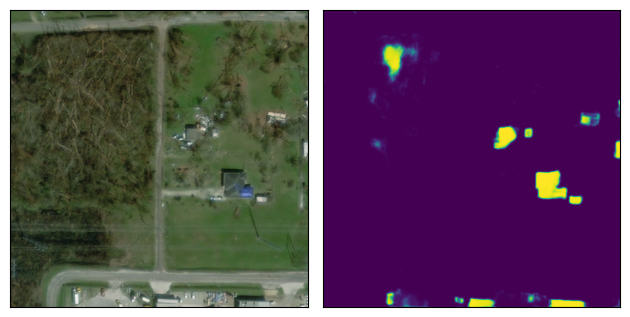

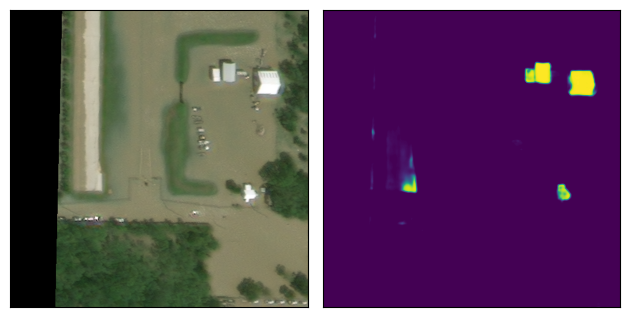

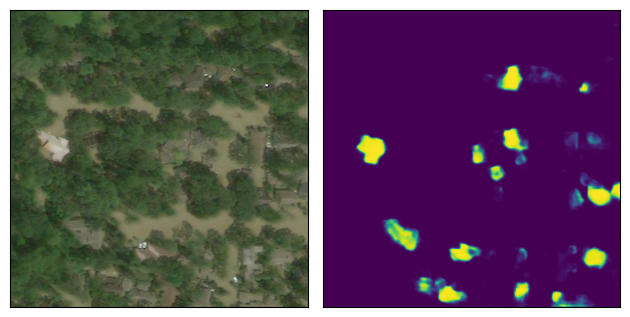

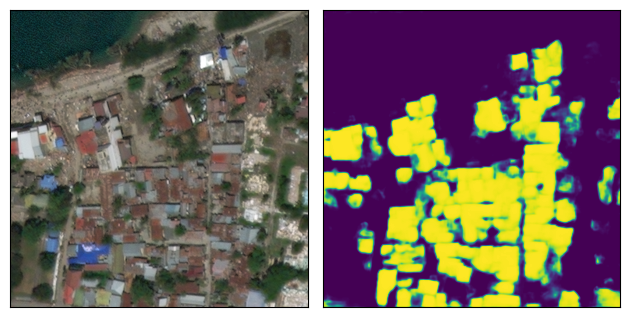

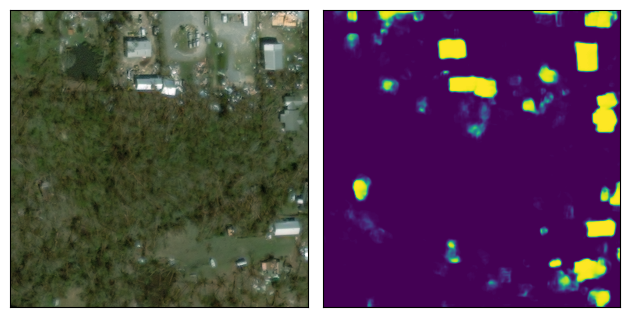

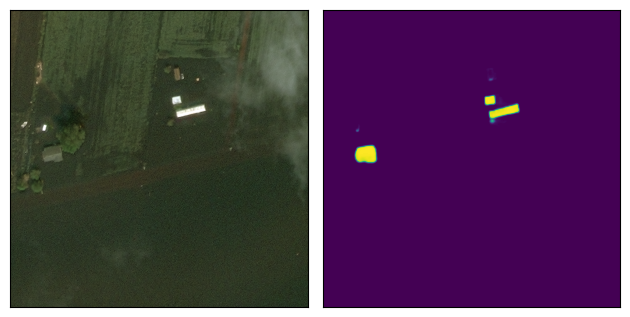

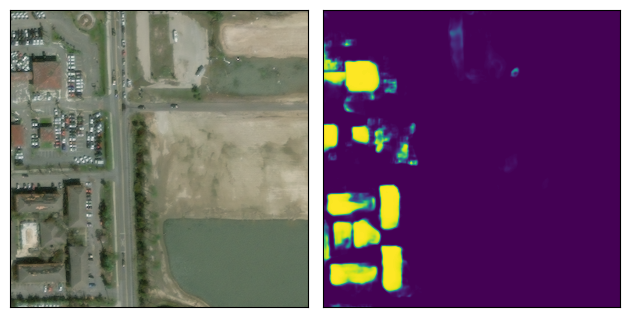

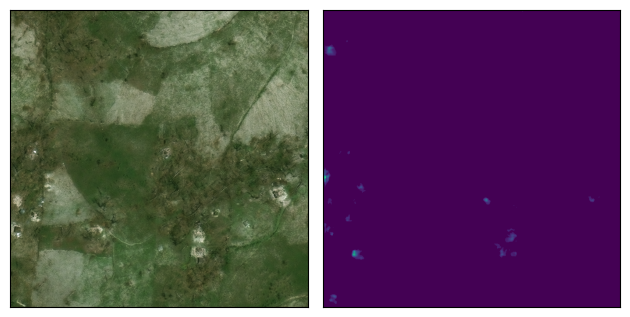

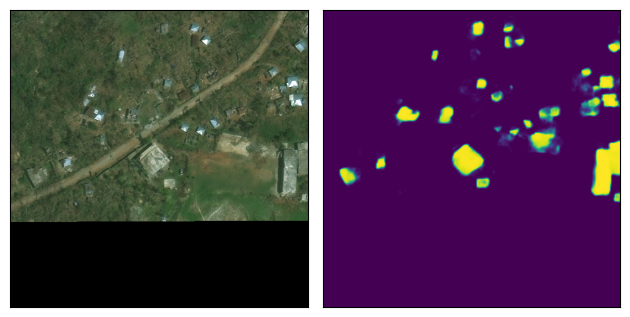

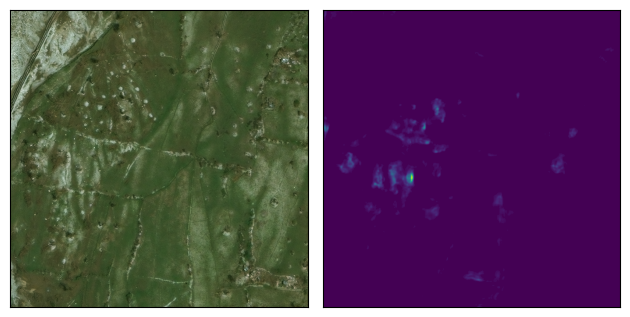

In [ ]:
sm_unet_output[sm_unet_output < 0.01] = 0
for i in range(10):
    plt.figure()
    plt.subplot(121), plt.imshow((x_pre_test[i, :, :, :] - np.min(x_pre_test[i, :, :, :])) / np.max(x_pre_test[i, :, :, :] - np.min(x_pre_test[i, :, :, :])))
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(sm_unet_output[i, :, :, :])
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

## ✌ Make it DOUBLE!

### Define the base model (without its last layer)

In [ ]:
def decay_schedule(epoch, lr):
    if epoch < 10:
        lr = 0.02
    elif (epoch >= 10) and (epoch < 20):
        lr = 0.002
    elif epoch >= 20:
        lr = 0.0002
    return lr

In [ ]:
# BACKBONE = 'resnet34'
BACKBONE = 'efficientnetb7'
preprocess_input = get_preprocessing(BACKBONE)
BATCH = 3
PATCH = 256
CLASSES = ['no-damage', 'minor-damage', 'major-damage', 'destroyed']
EPOCHS = 30

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# LR = 0.0001
# optimizer = keras.optimizers.Adam(LR)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
lr_scheduler = LearningRateScheduler(decay_schedule)

dice_loss = sm.losses.DiceLoss()
bf_loss = sm.losses.BinaryFocalLoss()           # ----
f_loss = sm.losses.CategoricalFocalLoss()
bce_loss = sm.losses.BinaryCELoss()             # ----
ce_loss = sm.losses.CategoricalCELoss()
total_loss = dice_loss + f_loss + ce_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

callbacks = [
    keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/model.sm.{BACKBONE}-unet-double.unet.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    lr_scheduler,
]

# We put 1 as n_classes because the model has been trained on localization.
model_sm_unet_4DOUBLE = Unet(BACKBONE, classes=1, encoder_weights='imagenet', encoder_freeze=True, activation=activation, input_shape=(PATCH, PATCH, 3))
model_sm_unet_4DOUBLE.load_weights(f'/content/drive/MyDrive/model.sm.{BACKBONE}.unet.h5')

258434480/258434480 [==============================] - 4s 0us/step


In [ ]:
last_layer = model_sm_unet_4DOUBLE.get_layer('decoder_stage4b_relu')
print(last_layer.output.shape)

# redefine model to output right after the first hidden layer
model_wo_head = Model(inputs=model_sm_unet_4DOUBLE.inputs, outputs=model_sm_unet_4DOUBLE.get_layer('decoder_stage4b_relu').output)
model_wo_head.trainable = False

(None, 256, 256, 16)


### Configure data generator to give both PRE & POST images

In [ ]:
class xBD_DataGenerator_4dual(keras.utils.Sequence):
    def __init__(self, path_to_jsons, batch_size=5, patch_size=256,
                 shuffle=True, classification=True):

        # Initialization -->
        self.path_to_jsons = path_to_jsons
        self.pre_img_paths = []
        self.post_img_paths = []
        self.loc_target_paths = []
        self.cls_target_paths = []

        for i in range(len(self.path_to_jsons)):
            # pre-disaster images
            self.pre_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/').replace('_post_', '_pre_') + '.png')
            # post-disaster images
            self.post_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/') + '.png')
            if 'tier3' not in self.path_to_jsons[i]:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_post_', '_pre_') + '_target.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '_target.png')
            else:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_post_', '_pre_') + '.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '.png')

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.classification = classification    # Whether you want to perform classification or localization.
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch (steps per epoch) [N_batch]
        return int(len(self.pre_img_paths) // self.batch_size)

    def __getitem__(self, idx):
        # Returns image indices of a batch
        # Generate one batch of data
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        pre_image_batch = list(np.array(self.pre_img_paths)[batch_indices])
        post_image_batch = list(np.array(self.post_img_paths)[batch_indices])
        loc_target_batch = list(np.array(self.loc_target_paths)[batch_indices])
        cls_target_batch = list(np.array(self.cls_target_paths)[batch_indices])

        # Generates data containing batch_size samples # X : (n_samples, *dim, n_channels)
        # Initialization
        x_pre_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        x_post_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        y_target_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (5,), dtype='float32')
        # Generate data
        for b in range(self.batch_size):
            pre_image = imread(pre_image_batch[b])
            post_image = imread(post_image_batch[b])
            if self.classification:
                target_image = imread(cls_target_batch[b])
                # Treat "unclassified" as no-damage
                target_image[target_image == 5] = 1

                # for CATEGORICAL ONE-HOT classes
                categorical = np.zeros((target_image.shape[0], target_image.shape[1], 5))
                categorical[:, :, 0] = target_image == 0
                categorical[:, :, 1] = target_image == 1
                categorical[:, :, 2] = target_image == 2
                categorical[:, :, 3] = target_image == 3
                categorical[:, :, 4] = target_image == 4
                target_image = categorical

            else:
                target_image = imread(loc_target_batch[b])

            # Perform a random cropping and put images into batch array.
            r_start, c_start = np.random.randint(low=0, high=(pre_image.shape[0] - self.patch_size), size=2)
            x_pre_batch[b] = preprocess_input(pre_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])       # preprocess input images based on backbone preprocessing
            x_post_batch[b] = preprocess_input(post_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])     # preprocess input images based on backbone preprocessing
            y_target_batch[b] = target_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :]

        return (x_pre_batch, x_post_batch), y_target_batch

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Training data generation
training_files = []
cond0 = db['Group'] == 'Train'                # use images in Train folder
cond1 = db['buildings#'] > 20                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['minor-damage#'] + db['major-damage#'] > 0
training_files = list(db[cond0 & cond2 & cond3]['img_name'])
print(len(training_files))

# Testing data generation
testing_files = []
cond0 = db['Group'] == 'Test'                 # use images in Train folder
cond1 = db['destroyed#'] > 0                  # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['major-damage#'] + db['minor-damage#'] > 5
testing_files = list(db[cond0 & cond2 & cond3]['img_name'])
print(len(testing_files))

# Validation data generation
validation_files = []
cond0 = db['Group'] == 'Hold'                 # use images in Train folder
cond1 = db['buildings#'] > 30                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['minor-damage#'] + db['major-damage#'] > 20
validation_files = list(db[cond0 & cond2 & cond3]['img_name'])
print(len(validation_files))

parameters = {'shuffle': True, 'batch_size': BATCH, 'patch_size': PATCH, 'classification': True}

train_generator = xBD_DataGenerator_4dual(path_to_jsons=training_files, **parameters)
test_generator = xBD_DataGenerator_4dual(path_to_jsons=testing_files, **parameters)
valid_generator = xBD_DataGenerator_4dual(path_to_jsons=validation_files, **parameters)

1501
292
155


### Visualize last features
Visualize features of the localization part.

In [ ]:
(x_pre, x_post), y_mask = test_generator.__getitem__(20)
x_pre.shape, x_post.shape, y_mask.shape, np.min(x_pre), np.max(x_pre), np.min(x_post), np.max(x_post), np.min(y_mask), np.max(y_mask)

In [ ]:
feature_maps = model_wo_head.predict(x_pre)
print(feature_maps.shape)

1/1 [==============================] - 11s 11s/step
(3, 256, 256, 16)


In [ ]:
count = 1
plt.figure(figsize=(10, 15))
for i in range(BATCH):
    plt.subplot(BATCH, 3, count), plt.xticks([]), plt.yticks([])
    # plt.imshow(x_pre[i].astype(int))
    plt.imshow((x_pre[i, :, :, :] - np.min(x_pre[i, :, :, :])) / np.max(x_pre[i, :, :, :] - np.min(x_pre[i, :, :, :])))
    plt.subplot(BATCH, 3, count+1), plt.xticks([]), plt.yticks([])
    # plt.imshow(x_post[i].astype(int))
    plt.imshow((x_post[i, :, :, :] - np.min(x_post[i, :, :, :])) / np.max(x_post[i, :, :, :] - np.min(x_post[i, :, :, :])))
    plt.subplot(BATCH, 3, count+2), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(y_mask[i], axis=2), vmin=0, vmax=4)
    count += 3
plt.tight_layout()
plt.show()

In [ ]:
count = 1
plt.figure(figsize=(15, 8))
for i in range(BATCH):
    for j in range(16):
        plt.subplot(BATCH, 16, count), plt.xticks([]), plt.yticks([])
        plt.imshow(feature_maps[i, :, :, j], cmap='jet')
        count += 1
plt.tight_layout()
plt.show()

### Construct the siamese netowrk

In [ ]:
from keras.initializers import he_normal

In [ ]:
# create the left input and point to the base network
input_pre = Input(shape=(PATCH, PATCH, 3), name="pre_input")
output_pre = model_wo_head(input_pre)

# create the right input and point to the base network
input_post = Input(shape=(PATCH, PATCH, 3), name="post_input")
output_post = model_wo_head(input_post)

head = Concatenate()([output_pre, output_post])
# head = Conv2D(16, (3, 3), padding='same', name='middle_conv')(head)
head = BatchNormalization()(head)
head = Conv2D(n_classes, (3, 3), padding='same', kernel_initializer=he_normal(), name='class_conv')(head)
output = Activation("sigmoid")(head)

# specify the inputs and output of the model
siamese = Model([input_pre, input_post], output)
siamese.compile(optimizer, loss=total_loss, metrics=metrics)

In [ ]:
# siamese.load_weights('/content/drive/MyDrive/model.sm.resnet34-unet-double.unet-v2.h5')   # For continuing training process

In [ ]:
history = siamese.fit(
    train_generator,
    validation_data=valid_generator,
    use_multiprocessing=True,
    workers=6, epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Visualize predictions
Visualize classification prediction results.

In [ ]:
# siamese.load_weights('/content/drive/MyDrive/model.sm.resnet34-unet-double.unet-v2.h5')
siamese.load_weights('/content/drive/MyDrive/model.sm.efficientnetb7-unet-double.unet.h5')

1/1 [==============================] - 1s 562ms/step


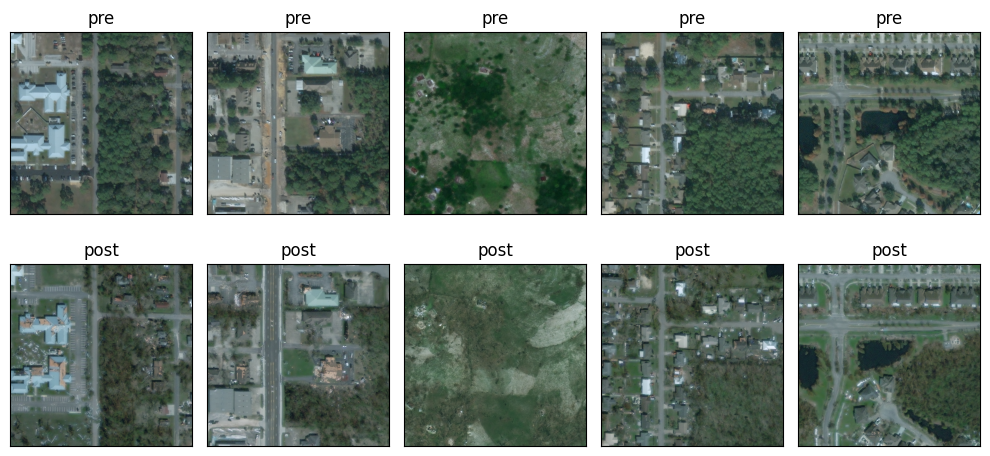

In [ ]:
(x_pre, x_post), y_mask = test_generator.__getitem__(1)
a = siamese.predict([x_pre, x_post])

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1), plt.xticks([]), plt.yticks([]), plt.title('pre')
    # plt.imshow(x_pre[i].astype(int))
    plt.imshow((x_pre[i, :, :, :] - np.min(x_pre[i, :, :, :])) / np.max(x_pre[i, :, :, :] - np.min(x_pre[i, :, :, :])))

    plt.subplot(2, 5, i + 6), plt.xticks([]), plt.yticks([]), plt.title('post')
    # plt.imshow(x_post[i].astype(int))
    plt.imshow((x_post[i, :, :, :] - np.min(x_post[i, :, :, :])) / np.max(x_post[i, :, :, :] - np.min(x_post[i, :, :, :])))

plt.tight_layout()
plt.show()

#### Without any color mapping

In [ ]:
count = 1
plt.figure(figsize=(20, 13))
for i in range(5):
    plt.subplot(5, 9, count), plt.xticks([]), plt.yticks([])
    plt.imshow(x_pre[i].astype(int)), plt.title('pre')
    plt.subplot(5, 9, count+1), plt.xticks([]), plt.yticks([])
    plt.imshow(x_post[i].astype(int)), plt.title('post')
    plt.subplot(5, 9, count+2), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(y_mask[i], axis=2), vmin=0, vmax=4), plt.title('GT')

    plt.subplot(5, 9, count+3), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 0]), 2))
    max_ = str(round(np.max(a[i, :, :, 0]), 2))
    plt.imshow(a[i, :, :, 0], vmin=0, vmax=1), plt.title('ch 1-backgound'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+4), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 1]), 2))
    max_ = str(round(np.max(a[i, :, :, 1]), 2))
    plt.imshow(a[i, :, :, 1], vmin=0, vmax=1), plt.title('ch 2-no-damage'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+5), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 2]), 2))
    max_ = str(round(np.max(a[i, :, :, 2]), 2))
    plt.imshow(a[i, :, :, 2], vmin=0, vmax=1), plt.title('ch 3-minor'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+6), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 3]), 2))
    max_ = str(round(np.max(a[i, :, :, 3]), 2))
    plt.imshow(a[i, :, :, 3], vmin=0, vmax=1), plt.title('ch 4-major'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+7), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 4]), 2))
    max_ = str(round(np.max(a[i, :, :, 4]), 2))
    plt.imshow(a[i, :, :, 4], vmin=0, vmax=1), plt.title('ch 5-destroyed'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+8), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(a[i], axis=2), vmin=0, vmax=4), plt.title('classification')

    count += 9
plt.tight_layout()
plt.show()

#### Trying on TP, FP, FN, and TN. Applying color maps.

In [ ]:
c = mpl.colors.ListedColormap(['midnightblue', 'green', 'ivory', 'orange', 'red'])
n = mpl.colors.Normalize(vmin=0, vmax=5)

c1 = mpl.colors.ListedColormap(['white', 'red', 'blue', 'lime'])
n1 = mpl.colors.Normalize(vmin=1, vmax=4)

In [ ]:
count = 1
plt.figure(figsize=(20, 13))
for i in range(5):
    plt.subplot(5, 9, count), plt.xticks([]), plt.yticks([])
    plt.imshow(x_pre[i].astype(int)), plt.title('pre')
    plt.subplot(5, 9, count+1), plt.xticks([]), plt.yticks([])
    plt.imshow(x_post[i].astype(int)), plt.title('post')
    plt.subplot(5, 9, count+2), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(y_mask[i], axis=2), cmap=c, norm=n), plt.title('GT')

    plt.subplot(5, 9, count+3), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(a[i], axis=2), cmap=c, norm=n), plt.title('classification')

    plt.subplot(5, 9, count+4), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 0]), 2))
    max_ = str(round(np.max(a[i, :, :, 0]), 2))
    plt.imshow(a[i, :, :, 0], vmin=0, vmax=1, cmap='gray'), plt.title('ch 1-backgound'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+5), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 1]), 2))
    max_ = str(round(np.max(a[i, :, :, 1]), 2))
    plt.imshow(a[i, :, :, 1], vmin=0, vmax=1, cmap='gray'), plt.title('ch 2-no-damage'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+6), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 2]), 2))
    max_ = str(round(np.max(a[i, :, :, 2]), 2))
    plt.imshow(a[i, :, :, 2], vmin=0, vmax=1, cmap='gray'), plt.title('ch 3-minor'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+7), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 3]), 2))
    max_ = str(round(np.max(a[i, :, :, 3]), 2))
    plt.imshow(a[i, :, :, 3], vmin=0, vmax=1, cmap='gray'), plt.title('ch 4-major'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(5, 9, count+8), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 4]), 2))
    max_ = str(round(np.max(a[i, :, :, 4]), 2))
    plt.imshow(a[i, :, :, 4], vmin=0, vmax=1, cmap='gray'), plt.title('ch 5-destroyed'), plt.xlabel(min_ + ', ' + max_)

    count += 9
plt.tight_layout()
plt.show()

In [ ]:
i = 4
pred_i = np.argmax(a[i], axis=2)
gt_i = np.argmax(y_mask[i], axis=2)

# THESE MEASURES WORK ONLY FOR LOCALIZATION VISUALIZATION (they must be configured to work for multiclass segmentation, too)
TN = (gt_i == 0) & (pred_i == 0)
# TP = (gt_i == pred_i) * ~TN
TP = (gt_i != 0) * (pred_i != 0)
# TP = (np.abs(pred_i - gt_i) < 2) * ~TN
FP = (pred_i != 0) * (gt_i == 0)
# FP = (pred_i != gt_i) * ~TN
FN = (pred_i == 0) * (gt_i != 0)

plt.figure(figsize=(15, 5))
# plt.subplot(161), plt.imshow(gt_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
# plt.subplot(162), plt.imshow(pred_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
# plt.subplot(163), plt.imshow(TN), plt.xticks([]), plt.yticks([])
# plt.subplot(164), plt.imshow(TP), plt.xticks([]), plt.yticks([])
# plt.subplot(165), plt.imshow(FP), plt.xticks([]), plt.yticks([])
# plt.subplot(166), plt.imshow(FN), plt.xticks([]), plt.yticks([])
plt.subplot(131), plt.imshow(gt_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(pred_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(TN * 1 + FN * 2 + FP * 3 + TP * 4, cmap=c1, norm=n1), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(x_pre[i].astype(int)), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(x_post[i].astype(int)), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
fm1 = Model(inputs=siamese.inputs, outputs=siamese.get_layer('conv2d').output)
o1 = fm1.predict([x_pre, x_post])
o1.shape

1/1 [==============================] - 10s 10s/step


(5, 256, 256, 16)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1), plt.xticks([]), plt.yticks([])
    plt.imshow(o1[2, :, :, i])
plt.tight_layout()
plt.show()